In [172]:
import os
import pandas as pd

df_list = []
for filename in os.listdir("/home/frankwoods/Desktop/lassie/data/processed_data"):
    df = pd.read_csv(f"/home/frankwoods/Desktop/lassie/data/processed_data/{filename}")
    df_list.append(df)

In [173]:
def extract_features(df):
    res = df["resistance"]
    return [
        res.mean(),
        res.std(),
        res.min(),
        res.max(),
        res.skew(),
        res.kurtosis(),
        (res > 0).mean(),  # proportion positive
        res.diff().abs().mean(),  # smoothness
        # Add more if desired
    ]

In [174]:
# def get_representation(df, )

# shape (n,m) where n is number of df and m is extracted feaetures
representation_list = []
for df in df_list:
    representation_list.append(extract_features(df))
print(f"example: {representation_list[0]}")  

example: [np.float64(0.1021797467496816), 0.09371445944851854, 0.0011380695364706, 0.3395864884960055, np.float64(1.2032118536762233), np.float64(0.4324815130391251), np.float64(1.0), np.float64(0.0036866373059574477)]


## K-Means Clustering Implementation w/ k-means++ init for centroids

In [175]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=6, init="k-means++", n_init=1000).fit(representation_list)
print(kmeans.labels_)
print(kmeans.score(representation_list))

# kmeans.predict # for predicting which cluster a data point belongs too

[3 5 3 5 5 0 2 2 5 5 5 3 3 4 5 3 5 3 4 0 1 5 5 2 5 3 5 3 0 5 0 0 0 0 0 4 2
 4 5 0 3 4 5 4 0 5 5 5 5 5 4 0 0 4 2 0 4 0 5 4 4 3 5 4 5 0 5 5 5 5]
-19.143147836609252


[3 5 3 5 5 0 2 2 5 5 5 3 3 4 5 3 5 3 4 0 1 5 5 2 5 3 5 3 0 5 0 0 0 0 0 4 2
 4 5 0 3 4 5 4 0 5 5 5 5 5 4 0 0 4 2 0 4 0 5 4 4 3 5 4 5 0 5 5 5 5]


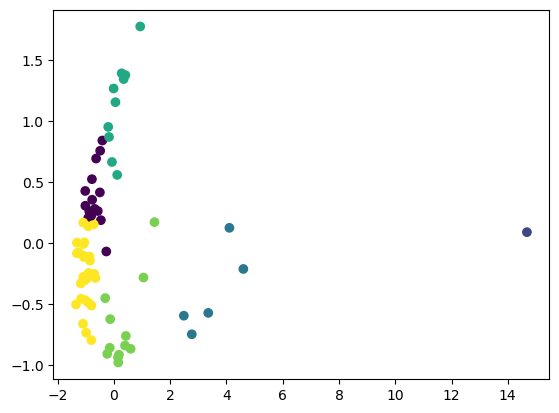

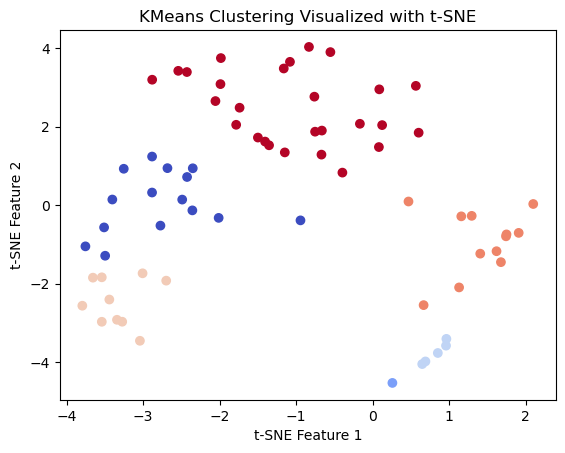

y_label: 0


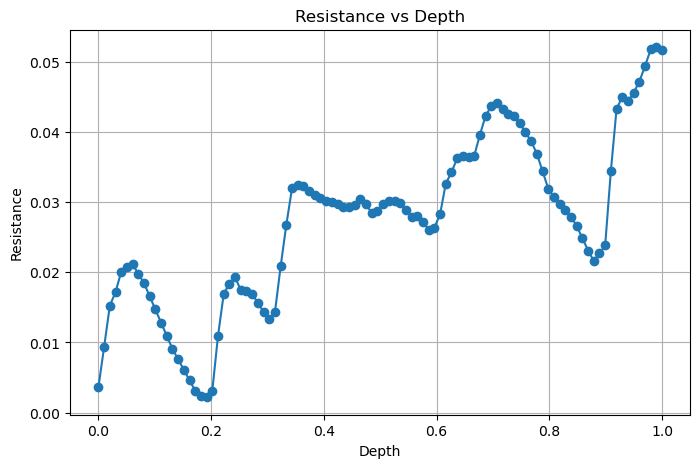

y_label: 0


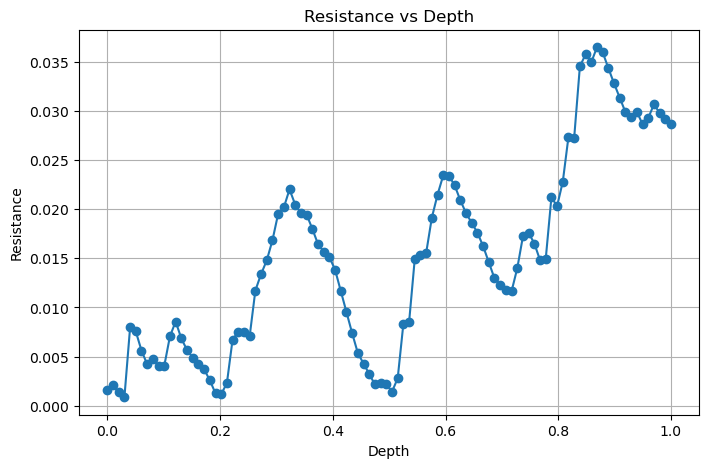

y_label: 1


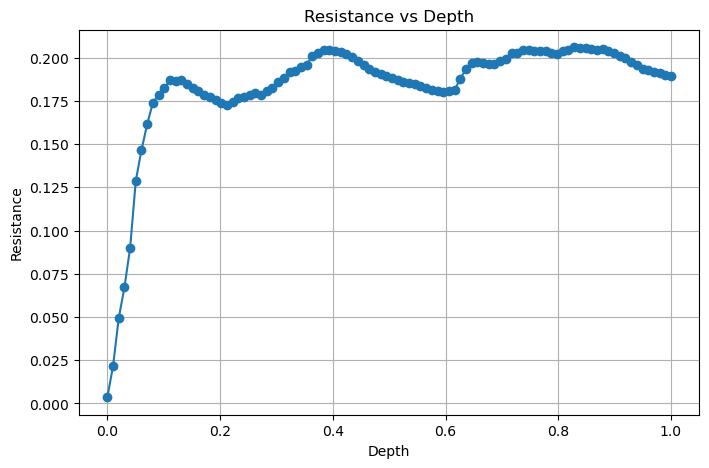

y_label: 2


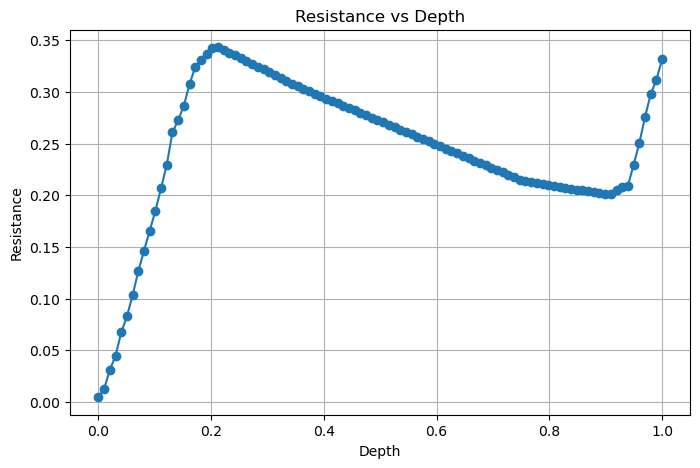

y_label: 2


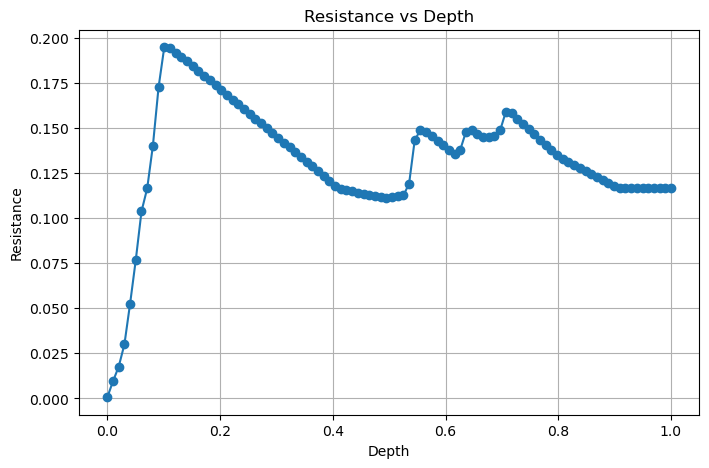

y_label: 3


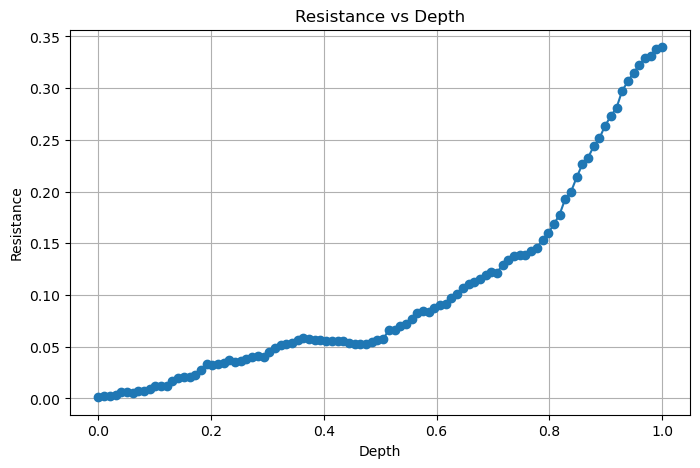

y_label: 3


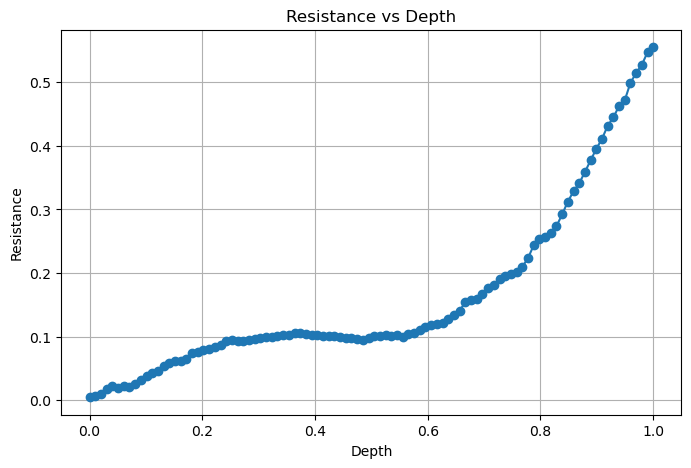

y_label: 4


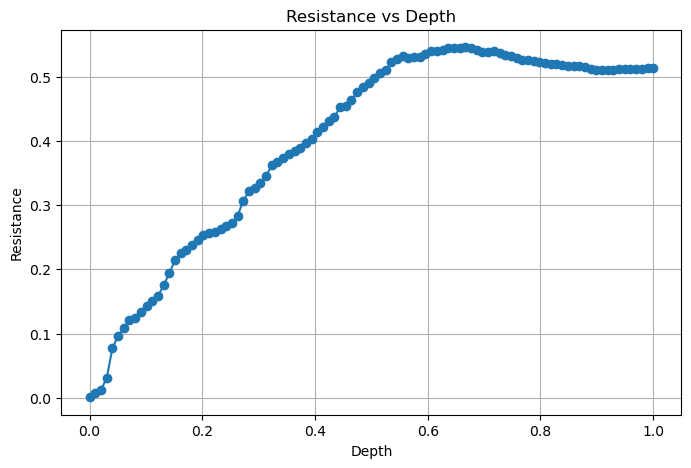

y_label: 4


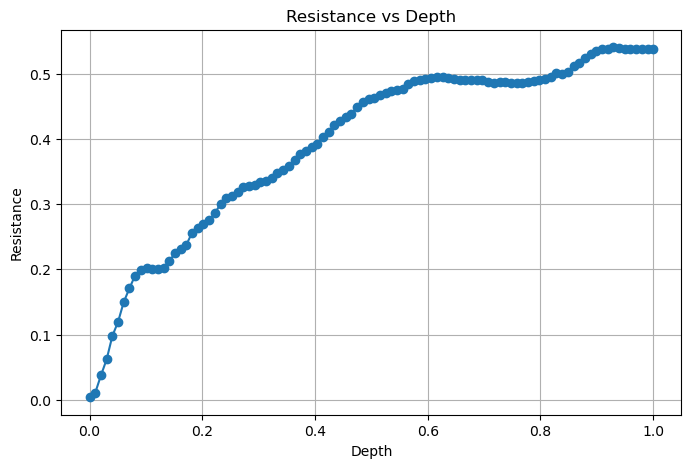

y_label: 5


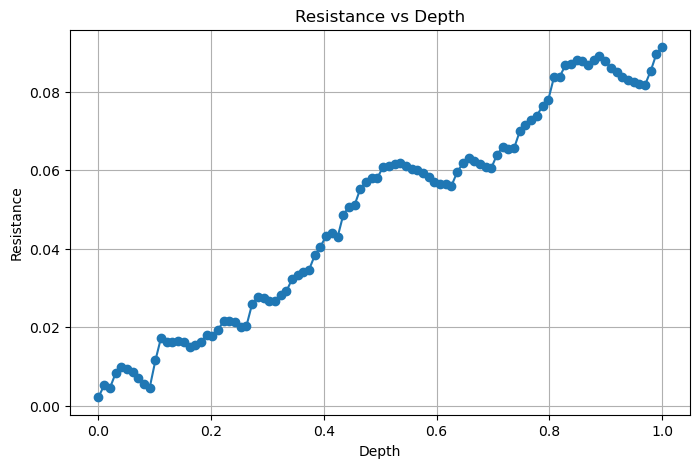

y_label: 5


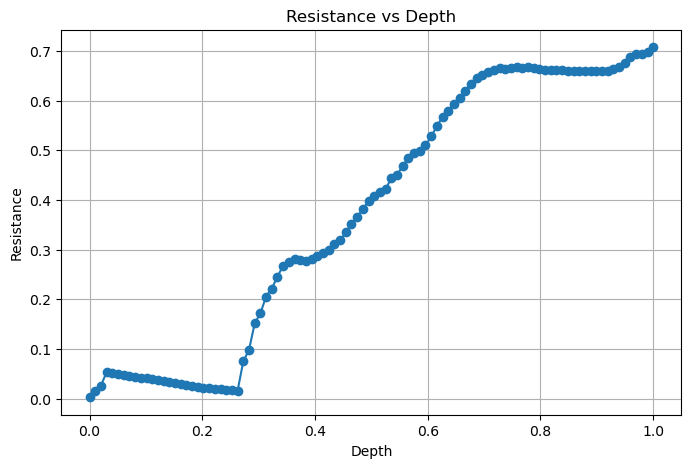

In [176]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_clusters(representation_list, y_labels, use_pca=False, use_sne=False):
    """
    A linear method that projects your data into a new 2D coordinate system that captures maximum variance.
    It compresses the data while retaining its most important patterns.
    Fast and good for general structure.
    """
    if use_pca:
        pca = PCA(n_components=2) # reduce data down to 2 dims
        X_pca = pca.fit_transform(representation_list) # learns directions of max vairance, projects onto 2D
        print(y_labels)
        # x_pca: x_dim, x_pca: y_dim, c: color points based on clusters, cmap: color map
        plt.scatter(X_pca[:,0], X_pca[:,1], c=y_labels, cmap='viridis')
        plt.show()
    """
    A nonlinear technique focused on preserving local neighborhoods.
    Often shows tight, separated clusters, even when PCA shows overlapping blobs.
    """
    if use_sne:
        tsne = TSNE(n_components=2, random_state=42)
        X_tsne = tsne.fit_transform(np.array(representation_list))
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_labels, cmap='coolwarm')
        plt.title("KMeans Clustering Visualized with t-SNE")
        plt.xlabel("t-SNE Feature 1")
        plt.ylabel("t-SNE Feature 2")
        plt.show()

def display_curve(df_list, graph_i):
    plt.figure(figsize=(8,5))         # Optional: set figure size
    plt.plot(df_list[graph_i]['depth'], df_list[graph_i]['resistance'], marker='o', linestyle='-')
    plt.xlabel('Depth')
    plt.ylabel('Resistance')
    plt.title('Resistance vs Depth')
    plt.grid(True)                    
    plt.show()

# display max 2 graphs per label
def visualize_cluster_curves(df_list, y_labels):
    # Index list
    df_list_i = list(range(len(df_list)))

    # Sort y_labels and indices together
    y_labels_sorted, df_list_sorted = zip(*sorted(zip(y_labels, df_list_i)))
    y_labels_sorted = list(y_labels_sorted)
    df_list_sorted = list(df_list_sorted)

    displayed_count = {}  # Track how many times we've displayed each label

    for i in range(len(y_labels_sorted)):
        label = y_labels_sorted[i]
        index = df_list_sorted[i]

        # Display at most 2 curves per label
        if displayed_count.get(label, 0) < 2:
            print(f"y_label: {label}")
            display_curve(df_list, index)
            displayed_count[label] = displayed_count.get(label, 0) + 1


visualize_clusters(representation_list, kmeans.labels_, use_pca=True, use_sne=True)
visualize_cluster_curves(df_list, kmeans.labels_)